# Long Analysis
# Plots for long-term performance: spectra, zonal mean, temporal mean, bias, EOFs, ACF, divergence, PDF, return periods.
# Configure runs in the setup cell below -- supports any number of runs.

In [21]:
import os, sys
from itertools import cycle

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

sys.path.append('..')

from src.inference.utils.long_metrics import return_period_bins, return_period_empirical
from src.inference.utils.plot_config import params, contourLevels, colormap

# ============================================================
# CONFIGURE RUNS HERE
# Each run is a dict with:
#   - "dir":   path to the long_analyses directory
#   - "label": legend label
#   - "dt_scale": (optional) multiplier on ACF/return-period time axis (default 1.0)
#                 e.g. training data saved 3x more frequently -> dt_scale=1/3
# Colors and linestyles are auto-assigned from the cycles below.
# You can override per-run by adding "color" and/or "linestyle" keys.
# ============================================================

runs = [
    {"dir": "/glade/derecho/scratch/dpatel/SSL-2DTurb/TRUTH/IC1/analysis/truth",
     "label": "Truth"},
    {"dir": "/glade/derecho/scratch/dpatel/SSL-2DTurb/BASE/BASE_seed_0_2phase_1000epochs/analysis/train",
     "label": "Train", "dt_scale": 1/3},
    {"dir": "/glade/derecho/scratch/jshen/pruning-turbulence-vit/vit128_1f/long_analyses",
     "label": "Emulator"},
    {"dir": "/glade/derecho/scratch/jshen/pruning-turbulence-vit/edvit0/base/long_analyses",
     "label": "ED-ViT"}, 
]

# ============================================================
# AUTO STYLE ASSIGNMENT
# ============================================================
_color_cycle = ['k', 'tab:red', 'tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:pink']
_ls_cycle = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1))]

for i, r in enumerate(runs):
    r.setdefault("color", _color_cycle[i % len(_color_cycle)])
    r.setdefault("linestyle", _ls_cycle[i % len(_ls_cycle)])
    r.setdefault("dt_scale", 1.0)

n_runs = len(runs)

# Grid parameters
Lx, Ly = 2 * np.pi, 2 * np.pi
Nx, Ny = 256, 256

# Spectra

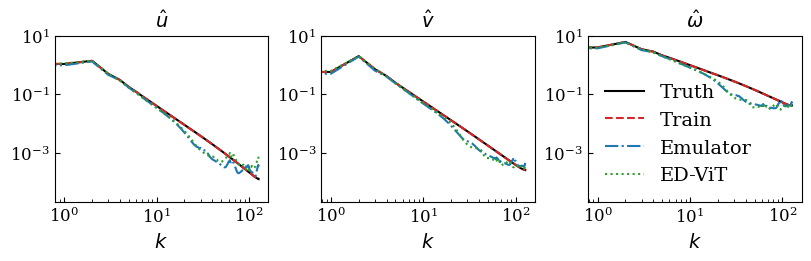

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5), layout="compressed")
plt.rcParams.update(params)

for r in runs:
    data = np.load(r["dir"] + "/spectra.npz")
    wn = data['wavenumber_zonal_avg']
    for ax, key in zip(axes, ['spectra_U_zonal_avg', 'spectra_V_zonal_avg', 'spectra_Omega_zonal_avg']):
        ax.loglog(wn[:-1], data[key][:-1], color=r["color"], ls=r["linestyle"], label=r["label"])

for ax in axes:
    ax.set_xlabel('$k$')
    ax.set_ylim([2e-5, 1e1])

axes[0].set_title(r'$\hat{u}$')
axes[1].set_title(r'$\hat{v}$')
axes[2].set_title(r'$\hat{\omega}$')
axes[-1].legend(frameon=False)

# Zonal Mean

Zonal Mean Pairwise Correlations:
  (Truth, Train)  U: 0.989  Omega: 0.996
  (Truth, Emulator)  U: 0.784  Omega: 0.910
  (Truth, ED-ViT)  U: 0.866  Omega: 0.947
  (Train, Emulator)  U: 0.791  Omega: 0.913
  (Train, ED-ViT)  U: 0.859  Omega: 0.944
  (Emulator, ED-ViT)  U: 0.406  Omega: 0.739


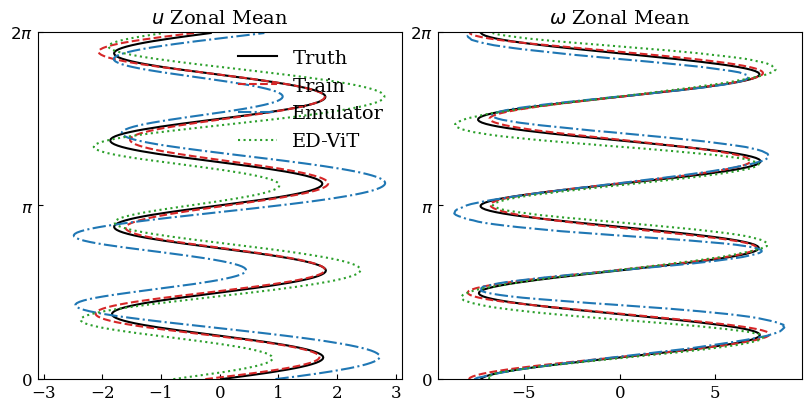

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), layout="compressed")
plt.rcParams.update(params)

dx = Lx / Nx
y = np.linspace(0, 2 * np.pi - dx, Nx)

zonal_U_all, zonal_Omega_all = [], []

for r in runs:
    data = np.load(r["dir"] + "/zonal_mean.npz")
    U_zm, Om_zm = data['U_zonal_mean'], data['Omega_zonal_mean']
    zonal_U_all.append(U_zm)
    zonal_Omega_all.append(Om_zm)
    axes[0].plot(U_zm, y, color=r["color"], ls=r["linestyle"], label=r["label"])
    axes[1].plot(Om_zm, y, color=r["color"], ls=r["linestyle"], label=r["label"])

axes[0].set_title(r'$u$ Zonal Mean')
axes[1].set_title(r'$\omega$ Zonal Mean')

for ax in axes:
    ax.set_yticks([0, np.pi, 2 * np.pi])
    ax.set_yticklabels(['0', r'$\pi$', r'$2\pi$'])
    ax.set_ylim([0, 2 * np.pi])

U_max = max(np.max(np.abs(z)) for z in zonal_U_all)
Om_max = max(np.max(np.abs(z)) for z in zonal_Omega_all)
axes[0].set_xlim([-1.1 * U_max, 1.1 * U_max])
axes[1].set_xlim([-1.1 * Om_max, 1.1 * Om_max])
axes[0].legend(frameon=False)

# Pairwise correlations
print("Zonal Mean Pairwise Correlations:")
for i in range(n_runs):
    for j in range(i + 1, n_runs):
        cu = pearsonr(zonal_U_all[i], zonal_U_all[j])[0]
        co = pearsonr(zonal_Omega_all[i], zonal_Omega_all[j])[0]
        print(f"  ({runs[i]['label']}, {runs[j]['label']})  U: {cu:.3f}  Omega: {co:.3f}")

# Temporal Mean

Text(0.5, 0.98, 'Temporal Mean')

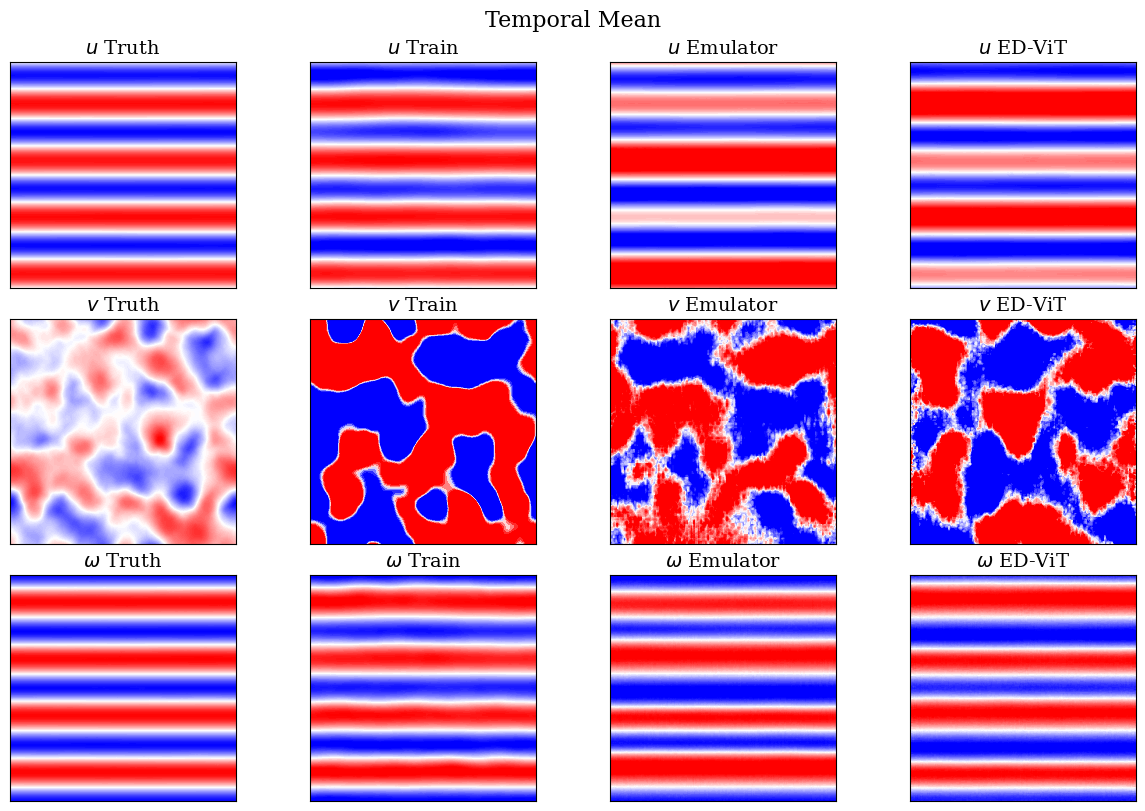

In [24]:
# Load all temporal means
tm_data = []
for r in runs:
    data = np.load(r["dir"] + "/temporal_mean.npz")
    tm_data.append((data['U_sample_mean'], data['V_sample_mean'], data['Omega_sample_mean']))

# Color scale from first run (Truth)
vmax_U = np.max(np.abs(tm_data[0][0]))
vmax_V = np.max(np.abs(tm_data[0][1]))
vmax_Om = np.max(np.abs(tm_data[0][2]))

fig, axes = plt.subplots(3, n_runs, figsize=(3 * n_runs, 8), layout='constrained', squeeze=False)
plt.rcParams.update(params)

for i, r in enumerate(runs):
    U_m, V_m, Om_m = tm_data[i]
    axes[0, i].contourf(U_m, levels=contourLevels, cmap=colormap, vmax=vmax_U, vmin=-vmax_U)
    axes[1, i].contourf(V_m, levels=contourLevels, cmap=colormap, vmax=vmax_V, vmin=-vmax_V)
    axes[2, i].contourf(Om_m, levels=contourLevels, cmap=colormap, vmax=vmax_Om, vmin=-vmax_Om)

    axes[0, i].set_title(rf"$u$ {r['label']}")
    axes[1, i].set_title(rf"$v$ {r['label']}")
    axes[2, i].set_title(rf"$\omega$ {r['label']}")

for ax in axes.flat:
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Temporal Mean')

# Bias: Temporal Mean

Temporal Mean Pairwise Correlations:
  (Truth, Train)  U: 0.988
  (Truth, Train)  V: 0.119
  (Truth, Train)  Omega: 0.995
  (Truth, Emulator)  U: 0.784
  (Truth, Emulator)  V: -0.228
  (Truth, Emulator)  Omega: 0.909
  (Truth, ED-ViT)  U: 0.866
  (Truth, ED-ViT)  V: -0.112
  (Truth, ED-ViT)  Omega: 0.947
  (Train, Emulator)  U: 0.789
  (Train, Emulator)  V: -0.510
  (Train, Emulator)  Omega: 0.911
  (Train, ED-ViT)  U: 0.858
  (Train, ED-ViT)  V: 0.051
  (Train, ED-ViT)  Omega: 0.942
  (Emulator, ED-ViT)  U: 0.405
  (Emulator, ED-ViT)  V: 0.128
  (Emulator, ED-ViT)  Omega: 0.738


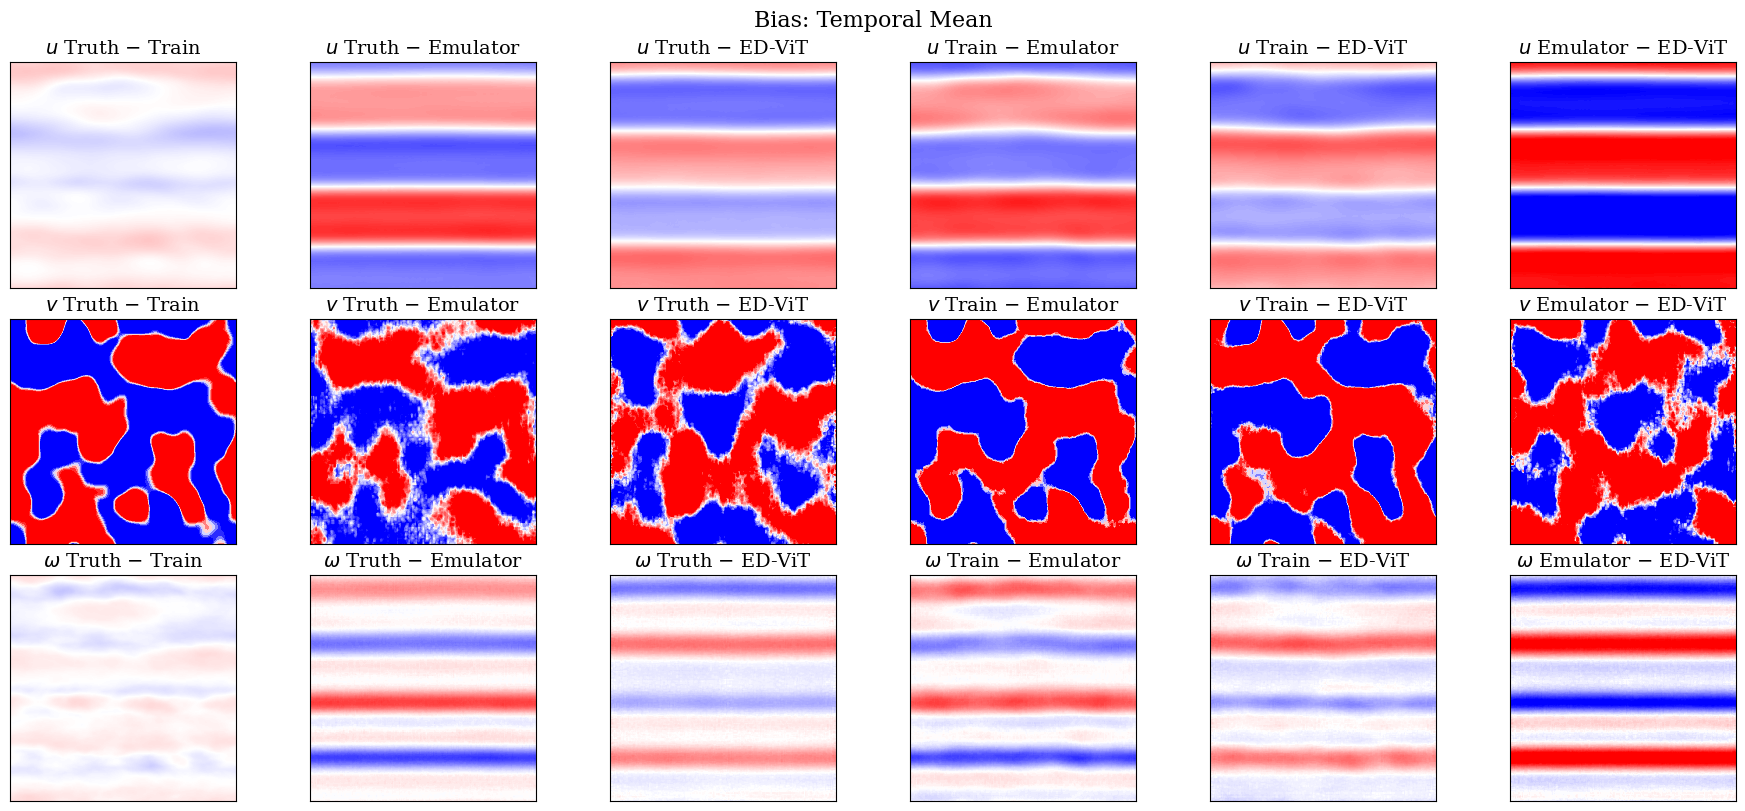

In [25]:
# Load temporal means for all runs
temporal_means = {}
for r in runs:
    data = np.load(r["dir"] + "/temporal_mean.npz")
    temporal_means[r["label"]] = {
        'U': data['U_sample_mean'], 'V': data['V_sample_mean'], 'Omega': data['Omega_sample_mean']
    }

from itertools import combinations
pairs = list(combinations(range(n_runs), 2))
n_pairs = len(pairs)

# Color scale from first run (Truth)
first = temporal_means[runs[0]["label"]]
vmax = {v: np.max(np.abs(first[v])) for v in ['U', 'V', 'Omega']}

fig, axes = plt.subplots(3, n_pairs, figsize=(3 * n_pairs, 8), layout='constrained', squeeze=False)
plt.rcParams.update(params)

for col, (i, j) in enumerate(pairs):
    li, lj = runs[i]["label"], runs[j]["label"]
    for row, var in enumerate(['U', 'V', 'Omega']):
        diff = temporal_means[li][var] - temporal_means[lj][var]
        axes[row, col].contourf(diff, levels=contourLevels, cmap=colormap,
                                vmax=vmax[var], vmin=-vmax[var])
        sym = {'U': 'u', 'V': 'v', 'Omega': r'\omega'}[var]
        axes[row, col].set_title(rf'${sym}$ {li} $-$ {lj}')

for ax in axes.flat:
    ax.set_aspect('equal', 'box')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle('Bias: Temporal Mean')

# Pairwise correlations
print("Temporal Mean Pairwise Correlations:")
for i, j in pairs:
    li, lj = runs[i]["label"], runs[j]["label"]
    for var in ['U', 'V', 'Omega']:
        c = pearsonr(temporal_means[li][var].flatten(), temporal_means[lj][var].flatten())[0]
        print(f"  ({li}, {lj})  {var}: {c:.3f}")

## EOF

Text(0.5, 1.0, '$u$ EOF 2')

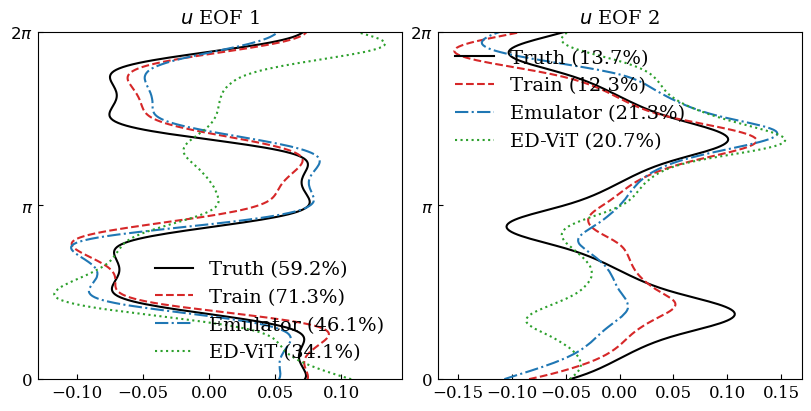

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), layout="compressed")
plt.rcParams.update(params)

y = np.linspace(0, Lx, Ny)
ref_eofs = None  # first run's EOFs used as sign reference

for r in runs:
    data = np.load(r["dir"] + "/zonal_eof_pc.npz", allow_pickle=True)
    EOF_U = data["U_eofs"]
    if EOF_U.shape[0] != Ny:
        EOF_U = EOF_U.T
    exp_var_U = 100 * data["U_expvar"]

    # Align EOF sign with the first run
    if ref_eofs is None:
        ref_eofs = EOF_U.copy()
    else:
        for k in range(min(2, EOF_U.shape[1])):
            if np.dot(EOF_U[:, k], ref_eofs[:, k]) < 0:
                EOF_U[:, k] *= -1

    for k in range(2):
        axes[k].plot(EOF_U[:, k], y, color=r["color"], ls=r["linestyle"],
                     label=rf'{r["label"]} ({exp_var_U[k]:.1f}%)')

for ax in axes:
    ax.set_yticks([0, np.pi, 2 * np.pi])
    ax.set_yticklabels(['0', r'$\pi$', r'$2\pi$'])
    ax.set_ylim([0, 2 * np.pi])
    ax.legend(frameon=False)

axes[0].set_title(r'$u$ EOF 1')
axes[1].set_title(r'$u$ EOF 2')

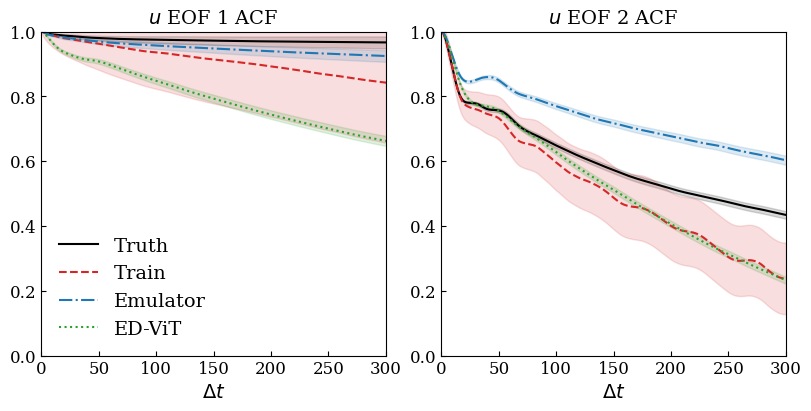

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4), layout='constrained')
plt.rcParams.update(params)

for r in runs:
    data = np.load(r["dir"] + "/zonal_eof_pc.npz", allow_pickle=True)
    PC_acf_U = data["U_pc_acf"]

    for k in range(2):
        acf = PC_acf_U[k]
        n_pts = acf['acf'].shape[0]
        time = np.linspace(0, n_pts * r["dt_scale"], n_pts)
        axes[k].plot(time, acf['acf'], color=r["color"], ls=r["linestyle"], label=r["label"])
        axes[k].fill_between(time, acf['confint'][:, 0], acf['confint'][:, 1],
                             color=r["color"], alpha=0.15)

for k in range(2):
    axes[k].set_title(rf'$u$ EOF {k+1} ACF')
    axes[k].set_xlabel(r'$\Delta t$')
    axes[k].set_ylim([0, 1])
    axes[k].set_xlim([0, 300])

axes[0].legend(frameon=False)

# Divergence

       Truth  mean=5.54e-06  std=2.09e-07
       Train  mean=5.56e-06  std=1.92e-07
    Emulator  mean=2.12e-01  std=1.61e-02
      ED-ViT  mean=3.16e-01  std=2.89e-02


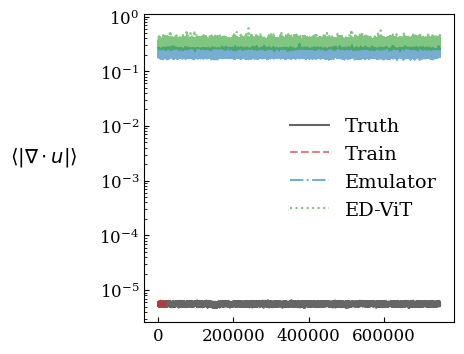

In [28]:
fig, ax = plt.subplots(1, figsize=(4, 4))
plt.rcParams.update(params)

for r in runs:
    div = np.load(r["dir"] + "/div.npy")
    ax.semilogy(div, color=r["color"], ls=r["linestyle"], label=r["label"], alpha=0.6)
    print(f'{r["label"]:>12s}  mean={div.mean():.2e}  std={div.std():.2e}')

ax.set_ylabel(r'$\langle |\nabla \cdot u| \rangle$', rotation=0, labelpad=40)
ax.legend(frameon=False)

## Return Period

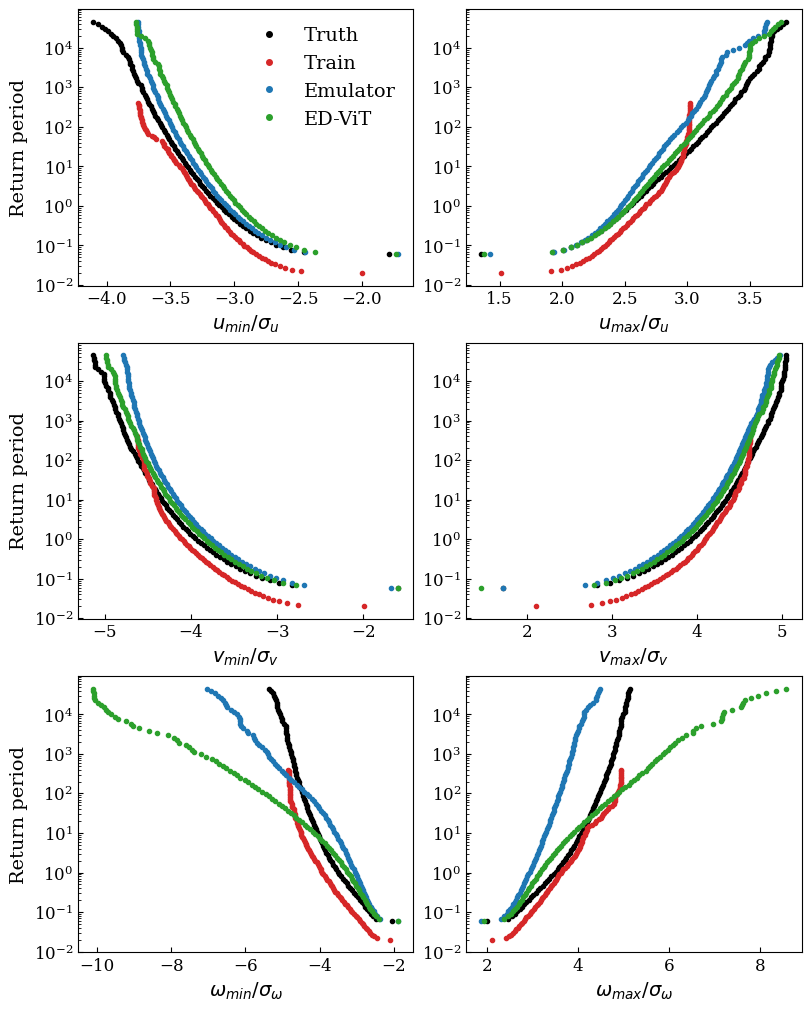

In [29]:
dt_data = 0.06
markersize = 3
U_std, V_std, Omega_std = 2.34, 1.88, 10.41
bins = 100

fig, axes = plt.subplots(3, 2, figsize=(8, 10), layout='constrained')
plt.rcParams.update(params)

for r in runs:
    data = np.load(os.path.join(r["dir"], "extremes.npz"))
    dt = dt_data * r["dt_scale"]

    fields = {
        'U': (data["U_max_arr"] / U_std, data["U_min_arr"] / U_std),
        'V': (data["V_max_arr"] / V_std, data["V_min_arr"] / V_std),
        'Omega': (data["Omega_max_arr"] / Omega_std, data["Omega_min_arr"] / Omega_std),
    }

    for row, (var, (fmax, fmin)) in enumerate(fields.items()):
        rp_max, amp_max = return_period_bins(fmax, dt=dt, bins_num=bins)
        rp_min, amp_min = return_period_bins(np.abs(fmin), dt=dt, bins_num=bins)
        axes[row, 0].semilogy(-amp_min, rp_min, 'o', color=r["color"], markersize=markersize, label=r["label"])
        axes[row, 1].semilogy(amp_max, rp_max, 'o', color=r["color"], markersize=markersize, label=r["label"])

var_labels = [('u', 'u'), ('v', 'v'), (r'\omega', r'\omega')]
for row, (sym, _) in enumerate(var_labels):
    axes[row, 0].set_ylabel('Return period')
    axes[row, 0].set_xlabel(rf'${sym}_{{min}}/\sigma_{{{sym}}}$')
    axes[row, 1].set_xlabel(rf'${sym}_{{max}}/\sigma_{{{sym}}}$')

custom_lines = [plt.Line2D([0], [0], color=r["color"], marker='o', lw=0, markersize=4, label=r["label"])
                for r in runs]
axes[0, 0].legend(handles=custom_lines, frameon=False)

# PDF

FileNotFoundError: [Errno 2] No such file or directory: '/glade/derecho/scratch/dpatel/SSL-2DTurb/TRUTH/IC1/analysis/truth/PDF_U.npz'

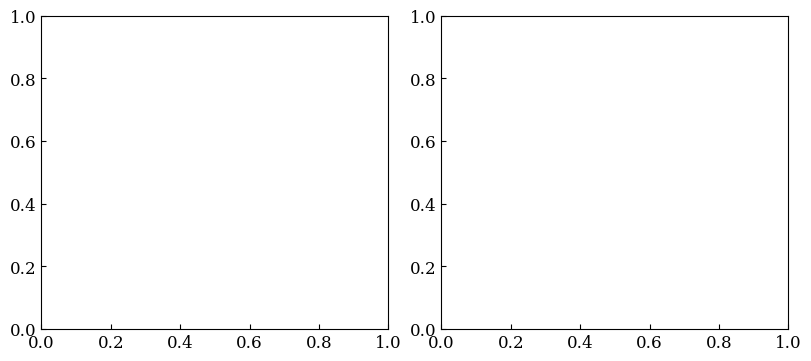

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3.5), layout="compressed")
plt.rcParams.update(params)

for r in runs:
    data_U = np.load(r["dir"] + "/PDF_U.npz")
    data_Om = np.load(r["dir"] + "/PDF_Omega.npz")

    axes[0].semilogy(data_U['U_bins'] / data_U['U_std'], data_U['U_pdf'],
                     color=r["color"], ls=r["linestyle"], label=r["label"])
    axes[1].semilogy(data_Om['Omega_bins'] / data_Om['Omega_std'], data_Om['Omega_pdf'],
                     color=r["color"], ls=r["linestyle"], label=r["label"])

axes[0].set_title(r'$u$ PDF')
axes[1].set_title(r'$\omega$ PDF')
axes[0].set_xlabel(r'$u/\sigma_u$')
axes[1].set_xlabel(r'$\omega/\sigma_{\omega}$')

for ax in axes:
    ax.set_ylim([1e-7, 1])
    ax.set_xlim([-5, 5])

axes[-1].legend(frameon=False)